In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('sample_900.csv')
df = df[df['sentiment'].isin(['0', '1', '2'])]
df = df.drop(df.columns[[0, 3]], axis=1)
df = df.dropna()
df.head()

,Group,Title,date,likes,comment,sentiment
0,NMIXX,별별별 (See that),2024-08-19T09:01:15Z,0.0,와씨 이번 컴백곡 미쳤다 (아직 안봄) 보고 왔는데 개지리누 춤연습 영상 빨리 빨리...,2
1,NMIXX,별별별 (See that),2024-08-19T09:04:49Z,0.0,오늘만 기다렸다,2
2,NMIXX,Party O’Clock,2023-07-11T19:22:59Z,0.0,아니 노래들이 점점 그냥 대중적으로 가자 제발 음악성 어쩌고저쩌고 모르겠고 듣기 편...,1
3,NMIXX,Party O’Clock,2023-07-12T10:27:02Z,4.0,근데 뉴진스 원래 조회수는 잘 안나옴 데뷔곡부터도 조회수 밀리는데,1
4,NMIXX,蜚蜚 (FEIFEI),2024-07-31T21:00:17Z,0.0,짜증나네.. 하필 ㅉㄲ 어로 노랠 부르다니..,0


# openai

In [2]:
#Use 3.12.4
import openai
import os
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, AIMessage, SystemMessage
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.docstore.document import Document

key_path = '/Users/jaesolshin/key/openai_key.txt'
os.environ["OPENAI_API_KEY"] = open(key_path, 'r', encoding='utf-8').read()
openai.api_key = os.environ["OPENAI_API_KEY"] 

In [25]:
import openai
import re
import time

# Sample 텍스트(50~52번 댓글)
comments = df['comment'][50:53]  # 슬라이싱 처리

# 감정 분석 함수 정의
def sentiment_by_gpt(comment):
    # OpenAI API를 사용하여 채팅 형식으로 요청
    response = openai.ChatCompletion.create(
        model="gpt-4",  # 사용할 모델
        messages=[
            {"role": "system", "content": "You are an expert sentiment analyst."},
            {"role": "user", "content": f"""문장의 감정을 "2" (긍정), "1" (중립), "0" (부정) 중 하나로 평가해 주세요. 숫자로만 응답하세요. 문장: "{comment}"\n감정:"""}
        ]
    )
    # 응답에서 메시지 내용 추출
    response_text = response['choices'][0]['message']['content'].strip()
    
    # 숫자만 추출
    score = re.search(r'\d', response_text)
    return score.group() if score else "N/A"

# 감정 분석 수행 및 결과 출력
for comment in comments:
    sentiment = sentiment_by_gpt(comment)
    print(f"댓글: {comment}\n감정: {sentiment}\n")
    time.sleep(0.06)  # API 속도 조절을 위한 지연 시간 설정


댓글: 사랑해...
감정: 2

댓글: @ 개인적으로는 충분하지는 않지만 만족스러운 곡인거 같아요.
감정: 2

댓글: 1집때보단 점점 나아지긴 했는데 정말 선곡 문제군. 왜 매번 기본적으로 비트와 멜로디가 평범한걸 선곡하는지 정말 이해가 안되네 보조 사운드로 아무리 포장하고 떡칠해도 기본베이스 비트와 멜로디가 별로면 모두 소용없는 짓인걸 모르나? 자체작곡가 역량이 딸리면 대형사에 데모곡들 엄청나게 들어 올텐데 외부곡에서 그중에서 골라도되고 그런데 데뷔전 영상보면서 정말 기대가 크고 애들 댄스 보컬 비쥬얼 삼박자가 수준이 정말 높아서 응원했는데 현재 4세대. 아이돌중에 가장 밑바닥 신세로 재능 낭비중 지금까지 이정도면 누가 선곡담당자인지 정말 재능이 없는 사람이다 다른 대형사들 아이돌 곡들고 나오는거 보라고 정말 신선하고 비트좋고 멜로디 좋고 그러니 대박나지 멤버들 재능이 아무리 좋으면 뭐하나 선곡재능이 꽝수준 막귀인데 농담삼아 유재석 탑백귀는 아니어도 탑200귀만 되어도 지금보다는 나을텐데 정말 문제군 중소돌이었으면 진작에 퇴출되었을텐데 jyp 빨로 버티는데 언제까지 갈지 안타깝다
감정: 0



In [ ]:
from tqdm import tqdm
tqdm.pandas()

df['sentiment_by_gpt'] = df['comment'].progress_apply(sentiment_by_gpt)

# Gemini

In [89]:
import google.generativeai as genai
import os

key_path = '/Users/jaesolshin/key/gemini_key.txt'
apikey = open(key_path, 'r', encoding='utf-8').read()
genai.configure(api_key=apikey)

system_instruction = "문장의 감정을 '2' (긍정), '1' (중립), '0' (부정) 중 하나로 평가해 주세요. {<텍스트 형식의 숫자>}"
model = genai.GenerativeModel("gemini-1.5-flash", system_instruction=system_instruction) # 모델 정의할 때 system_instruction 부여

# Sample 텍스트(50~52번 댓글)
comments = df['comment'][50:53]  # 슬라이싱 처리

def sentiment_by_gemini(comment):
    response = model.generate_content(comment)

    #print(response)  # 또는 response의 타입과 내용을 명확히 보기 위한 출력
    if not response.candidates:
        return "N/A"
    
    if not response.candidates[0].content.parts:
        return "N/A"
    
    response_text = response.candidates[0].content.parts[0].text.strip()
    
    score = re.search(r'\d', response_text)
    return score.group() if score else "N/A"

# 감정 분석 수행 및 결과 출력
for comment in comments:
    sentiment = sentiment_by_gemini(comment)
    print(f"댓글: {comment}\n감정: {sentiment}\n")

댓글: 사랑해...
감정: 2

댓글: @ 개인적으로는 충분하지는 않지만 만족스러운 곡인거 같아요.
감정: 1

댓글: 1집때보단 점점 나아지긴 했는데 정말 선곡 문제군. 왜 매번 기본적으로 비트와 멜로디가 평범한걸 선곡하는지 정말 이해가 안되네 보조 사운드로 아무리 포장하고 떡칠해도 기본베이스 비트와 멜로디가 별로면 모두 소용없는 짓인걸 모르나? 자체작곡가 역량이 딸리면 대형사에 데모곡들 엄청나게 들어 올텐데 외부곡에서 그중에서 골라도되고 그런데 데뷔전 영상보면서 정말 기대가 크고 애들 댄스 보컬 비쥬얼 삼박자가 수준이 정말 높아서 응원했는데 현재 4세대. 아이돌중에 가장 밑바닥 신세로 재능 낭비중 지금까지 이정도면 누가 선곡담당자인지 정말 재능이 없는 사람이다 다른 대형사들 아이돌 곡들고 나오는거 보라고 정말 신선하고 비트좋고 멜로디 좋고 그러니 대박나지 멤버들 재능이 아무리 좋으면 뭐하나 선곡재능이 꽝수준 막귀인데 농담삼아 유재석 탑백귀는 아니어도 탑200귀만 되어도 지금보다는 나을텐데 정말 문제군 중소돌이었으면 진작에 퇴출되었을텐데 jyp 빨로 버티는데 언제까지 갈지 안타깝다
감정: 0



In [90]:
df['sentiment_by_gemini'] = df['comment'].progress_apply(sentiment_by_gemini)

100%|██████████| 884/884 [05:28<00:00,  2.69it/s]


In [94]:
df[df['sentiment_by_gemini']=='N/A']

,Group,Title,date,likes,comment,sentiment,sentiment_by_gpt,sentiment_by_gemini
4,NMIXX,蜚蜚 (FEIFEI),2024-07-31T21:00:17Z,0.0,짜증나네.. 하필 ㅉㄲ 어로 노랠 부르다니..,0,0,N/A
59,NMIXX,"Young, Dumb, Stupid",2023-03-12T20:14:06Z,0.0,엔믹스 Young Dumb Stupid 신곡 대박 꽃길만 걷고 음악방송 1위 가자!!!,2,2,N/A
107,NewJeans,OMG,2024-04-28T15:35:33Z,7.0,계속 삭제 당하고 있는중.. 가사 -단 너 뿐이야 곰 - 단군 신화를 차용한 단월드...,0,0,N/A
115,NewJeans,OMG,2024-04-29T13:49:12Z,10.0,팩트 8가지 (이 내용 배댓이었는데 삭제된 거 같아요 좋아요랑 댓글 많이 달아 주세...,0,0,N/A
135,NewJeans,Attention,2022-07-22T05:40:49Z,4.0,ㅋㅋ와.. 뮤비 보고 놀란 거 진짜 오랜만이네.. 4세대 얘네가 다 먹겠구나,2,2,N/A
136,NewJeans,How Sweet,2024-05-29T15:26:08Z,2.0,뉴진스가 뉴진스함 시간은 뮤비 기준 처음에 해린이 영상 통화하는 장면 속 캐릭터 ...,2,0,N/A
191,NewJeans,OMG,2024-04-28T13:23:00Z,0.0,단월 드,0,0,N/A
226,FIFTY FIFTY,Cupid,2023-07-04T17:58:40Z,2.0,오십 오십은 바보야~ 널 1위로 올려준 사람을 왜 고소해?,0,0,N/A
241,FIFTY FIFTY,Cupid,2023-07-06T14:44:38Z,6.0,이지은도,1,1,N/A
249,FIFTY FIFTY,Cupid,2023-03-19T20:39:02Z,2.0,불 꺼진 romantic all my life 내 주위는 온통 lovely day ...,1,0,N/A


# 성능평가

정확도: 0.73


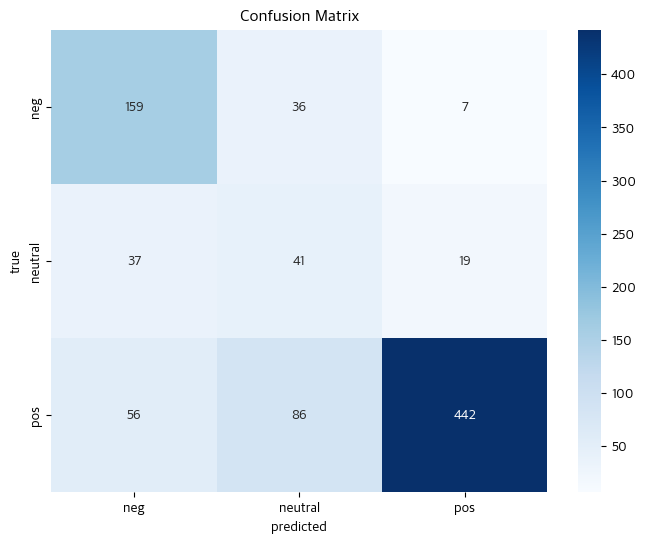

In [103]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# 폰트 패밀리 이름을 정확히 지정
plt.rc('font', family='Apple SD Gothic Neo')  # 폰트 패밀리 이름
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 표시

# gemini 결측 제거
valid_sentiments = ['0', '1', '2']
df_cleaned = df[df['sentiment_by_gpt'].isin(valid_sentiments)]

# 예시 데이터 생성
y_true = df_cleaned['sentiment']
y_pred = df_cleaned['sentiment_by_gpt']
# 정확도 계산
accuracy = accuracy_score(y_true, y_pred)
print(f"정확도: {accuracy:.2f}")

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg', 'neutral', 'pos'], yticklabels=['neg', 'neutral', 'pos'])
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('Confusion Matrix')
plt.show()

정확도: 0.74


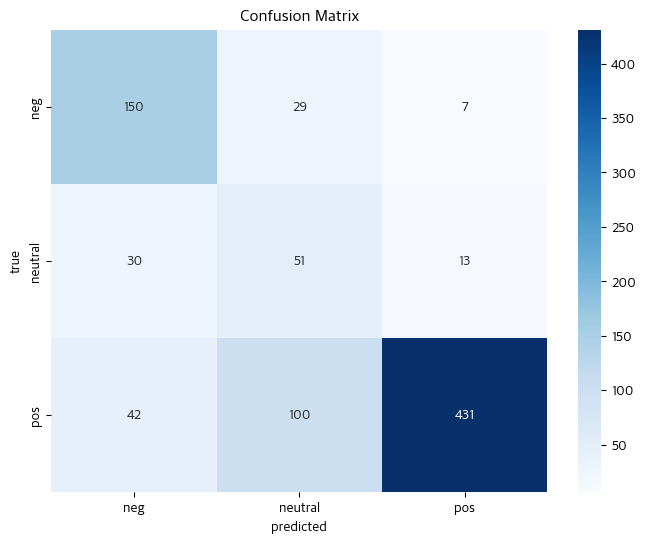

In [104]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# 폰트 패밀리 이름을 정확히 지정
plt.rc('font', family='Apple SD Gothic Neo')  # 폰트 패밀리 이름
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 표시

# gemini 결측 제거
valid_sentiments = ['0', '1', '2']
df_cleaned = df[df['sentiment_by_gemini'].isin(valid_sentiments)]


# 예시 데이터 생성
y_true = df_cleaned['sentiment']
y_pred = df_cleaned['sentiment_by_gemini']
# 정확도 계산
accuracy = accuracy_score(y_true, y_pred)
print(f"정확도: {accuracy:.2f}")

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg', 'neutral', 'pos'], yticklabels=['neg', 'neutral', 'pos'])
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('Confusion Matrix')
plt.show()

정확도: 0.81


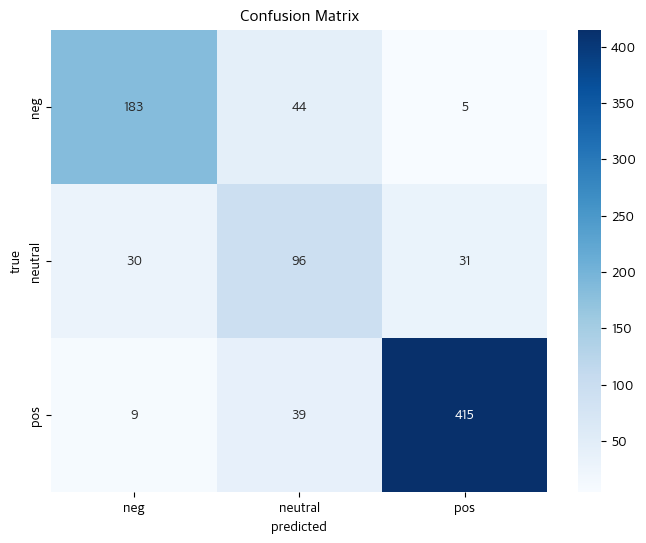

In [108]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# 폰트 패밀리 이름을 정확히 지정
plt.rc('font', family='Apple SD Gothic Neo')  # 폰트 패밀리 이름
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 표시

# gemini 결측 제거
valid_sentiments = ['0', '1', '2']
df_cleaned = df[df['sentiment_by_gpt'].isin(valid_sentiments) & df['sentiment_by_gemini'].isin(valid_sentiments)]

# 예시 데이터 생성
y_true = df_cleaned['sentiment_by_gpt']
y_pred = df_cleaned['sentiment_by_gemini']
# 정확도 계산
accuracy = accuracy_score(y_true, y_pred)
print(f"정확도: {accuracy:.2f}")

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg', 'neutral', 'pos'], yticklabels=['neg', 'neutral', 'pos'])
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('Confusion Matrix')
plt.show()

In [109]:
df.head()

,Group,Title,date,likes,comment,sentiment,sentiment_by_gpt,sentiment_by_gemini
0,NMIXX,별별별 (See that),2024-08-19T09:01:15Z,0.0,와씨 이번 컴백곡 미쳤다 (아직 안봄) 보고 왔는데 개지리누 춤연습 영상 빨리 빨리...,2,2,2
1,NMIXX,별별별 (See that),2024-08-19T09:04:49Z,0.0,오늘만 기다렸다,2,1,2
2,NMIXX,Party O’Clock,2023-07-11T19:22:59Z,0.0,아니 노래들이 점점 그냥 대중적으로 가자 제발 음악성 어쩌고저쩌고 모르겠고 듣기 편...,1,0,0
3,NMIXX,Party O’Clock,2023-07-12T10:27:02Z,4.0,근데 뉴진스 원래 조회수는 잘 안나옴 데뷔곡부터도 조회수 밀리는데,1,0,0
4,NMIXX,蜚蜚 (FEIFEI),2024-07-31T21:00:17Z,0.0,짜증나네.. 하필 ㅉㄲ 어로 노랠 부르다니..,0,0,N/A


/var/folders/hw/9m3g7fvn4_l3rp2y473km9sm0000gn/T/ipykernel_25308/313077737.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_likes, x='sentiment', y='likes', palette='viridis')


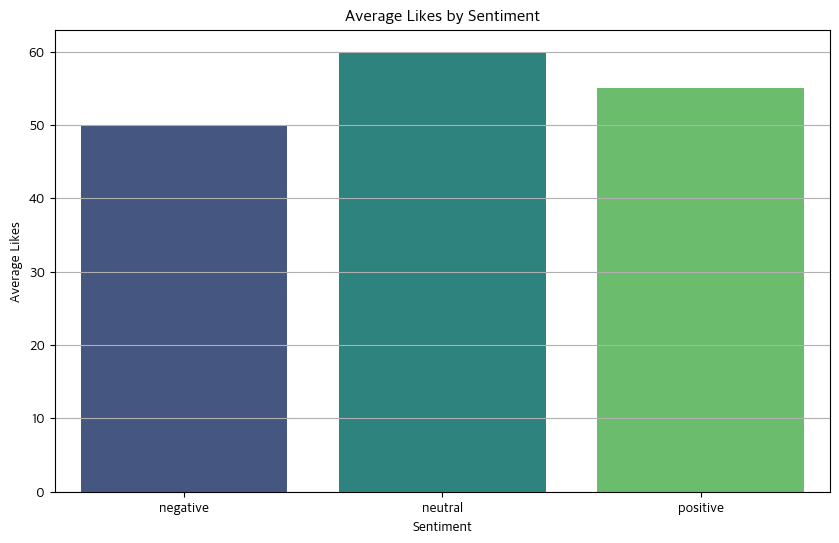

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 예시 DataFrame 생성
data = {
    'likes': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'sentiment': ['positive', 'negative', 'neutral', 'positive', 'negative', 
                  'neutral', 'positive', 'negative', 'neutral', 'positive']
}
df = pd.DataFrame(data)

# sentiment에 따른 likes의 평균 계산
mean_likes = df.groupby('sentiment')['likes'].mean().reset_index()

# 막대 그래프 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_likes, x='sentiment', y='likes', palette='viridis')
plt.title('Average Likes by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Likes')
plt.grid(axis='y')
plt.show()